In [1]:
# Importing libraries
# Importing model
import sys
sys.path.append("..")
from model_analysis.jnk3_no_ask1 import model
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import matplotlib.pyplot as plt
from model_analysis.equilibration_function import pre_equilibration
import sympy
from collections import OrderedDict
import pandas as pd

%matplotlib inline

In [2]:
# Loading fitted parameters
idx_pars_calibrate = [1, 5, 9, 11, 15, 17, 19, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream3
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

calibrated_pars = np.load('../model_analysis/most_likely_par_500000_4box.npy')
# calibrated_pars = np.load('calibrated_pars_pso1.npy') # most likely parameter from pydream calibration
param_values = np.array([p.value for p in model.parameters])

jnk3_initial_idxs = [47, 48, 49]
arrestin_idx = 44
kcat_idx = [36, 37]

par_set_calibrated = np.copy(param_values)
par_set_calibrated[rates_of_interest_mask] = 10 ** calibrated_pars

In [3]:
def plot_ppjnk3_production():
    """
    Plot ppJNK3 first and second phosphorylation
    Returns
    -------

    """
    # Pre-equilibration
    time_eq = np.linspace(0, 100, 100)
    pars_eq = np.copy(par_set_calibrated)
    pars_eq[[36, 37]] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc1 = pre_equilibration(model, time_eq, pars_eq)[1]
    tspan = np.linspace(0, 180, 181)
    sim2 = ScipyOdeSimulator(model, tspan, param_values=par_set_calibrated, initials=eq_conc1).run().all

    fig, axes = plt.subplots(ncols=3, figsize=(15, 3))
    fig.subplots_adjust(hspace=0.5)
    axes[0].set_title('JNK3 activation')
    axes[0].plot(tspan, sim2['all_jnk3'], color="#999999", label='ppJNK3')
    axes[0].plot(tspan, sim2['pThr_jnk3'] - sim2['__s4'], color="#E69F00", label='pThr-JNK3:Arr-3')
    axes[0].plot(tspan, sim2['pTyr_jnk3'] - sim2['__s5'], color="#56B4E9", label='pTyr-JNK3:Arr-3')
    axes[0].set_ylabel(r'Concentration [$\mu$M]', fontsize=12)
    axes[0].set_xlabel('Time(s)', fontsize=14)
    # plt.xlim(0, tspan[-1])

    par_name_idx = {j.name: i for i, j in enumerate(model.parameters)}

    # Selecting the reactions in which doubly phosphorylated JNK3 is involved
    rxns_pjnk3 = OrderedDict()
    rxns_pjnk3['mkk4 catalysis -Arr'] = model.reactions_bidirectional[21]['rate']
    rxns_pjnk3['mkk7 catalysis -Arr'] = model.reactions_bidirectional[23]['rate']
    rxns_pjnk3['mkk4 catalysis Arr'] = model.reactions_bidirectional[25]['rate']
    rxns_pjnk3['mkk7 catalysis Arr'] = model.reactions_bidirectional[27]['rate']

    rxns_ppjnk3 = OrderedDict()
    rxns_ppjnk3['mkk4 catalysis -Arr'] = model.reactions_bidirectional[22]['rate']
    rxns_ppjnk3['mkk7 catalysis -Arr'] = model.reactions_bidirectional[24]['rate']
    rxns_ppjnk3['mkk4 catalysis Arr'] = model.reactions_bidirectional[26]['rate']
    rxns_ppjnk3['mkk7 catalysis Arr'] = model.reactions_bidirectional[28]['rate']

    colors = ["#009E73", "#0072B2", "#D55E00", "#CC79A7"]

    counter = 0
    for label, rr in rxns_pjnk3.items():
        mon = rr
        var_to_study = [atom for atom in mon.atoms(sympy.Symbol)]
        arg_f1 = [0] * len(var_to_study)
        for idx, va in enumerate(var_to_study):
            if str(va).startswith('__'):
                sp_idx = int(''.join(filter(str.isdigit, str(va))))
                arg_f1[idx] = np.maximum(0, sim2['__s{0}'.format(sp_idx)])
            else:
                arg_f1[idx] = par_set_calibrated[par_name_idx[va.name]]

        f1 = sympy.lambdify(var_to_study, mon)
        mon_values = f1(*arg_f1)
        # print (label, mon_values)
        axes[1].semilogy(tspan, mon_values, label=label, color=colors[counter])
        counter += 1
    # axes[1].legend(loc=0, ncol=2, frameon=False)
    axes[1].set_title('JNK3 first phosphorylation reactions')
    axes[1].set_ylabel(r'Rate [$\mu$M/s]', fontsize=12)
    axes[1].set_xlabel('Time(s)', fontsize=14)
    # plt.xlim(0, tspan[-1])

    counter = 0
    for label, rr in rxns_ppjnk3.items():
        mon = rr
        var_to_study = [atom for atom in mon.atoms(sympy.Symbol)]
        arg_f1 = [0] * len(var_to_study)
        for idx, va in enumerate(var_to_study):
            if str(va).startswith('__'):
                sp_idx = int(''.join(filter(str.isdigit, str(va))))
                arg_f1[idx] = np.maximum(0, sim2['__s{0}'.format(sp_idx)])
            else:
                arg_f1[idx] = par_set_calibrated[par_name_idx[va.name]]

        f1 = sympy.lambdify(var_to_study, mon)
        mon_values = f1(*arg_f1)
        # print (label, mon_values)
        axes[2].semilogy(tspan[1:], mon_values[1:], label=label, color=colors[counter])
        counter += 1
    axes[2].set_title('JNK3 second phosphorylation reactions')
    axes[2].set_ylabel(r'Rate [$\mu$M/s]', fontsize=12)
    axes[2].set_xlabel('Time(s)', fontsize=14)

    box0 = axes[0].get_position()
    box1 = axes[1].get_position()
    box2 = axes[2].get_position()
    axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
    axes[1].set_position([box1.x0, box1.y0, box1.width * 0.8, box1.height])
    axes[2].set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])

    axes[0].legend(loc='lower right', frameon=False)
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

#     plt.savefig('ppjnk3_production.pdf', format='pdf', bbox_inches='tight')

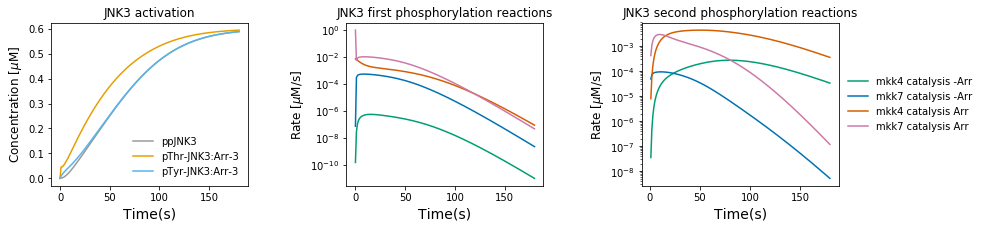

In [4]:
plot_ppjnk3_production()